In [7]:
#import tf
import tensorflow as tf
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import PIL.ImageGrab
from matplotlib.pyplot import imshow,subplots,plot
import seaborn as sns
%matplotlib inline

def print_img_from_clipboard():
    img = PIL.ImageGrab.grabclipboard()
    fig, ax = subplots(figsize=(90, 30))
    imshow(img, interpolation='nearest')

In [8]:
#import mnist
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST',one_hot=True)

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


In [9]:
#lets import iterate the batches to be used in train
def iterate_over_batches(input_array,batch_size=100):
    #input_values - np.array which is needed to be iterated
    #yeilds batched with size = batch_size
    total_values = len(list(input_array))
    #print(total_values)
    for index in range(int(total_values/batch_size)):
        start_index = index*batch_size
        end_index = start_index+batch_size
        yield input_array[start_index:end_index]
    if total_values%batch_size!=0.0:
        yield input_array[-int(total_values%batch_size):]

In [10]:
#lets define conv2d and maxpool wrappers
def conv2d(input_tensor,W,strides=1):
    return tf.nn.conv2d(input_tensor,W,strides=[1,strides,strides,1],padding='SAME')
#    with tf.name_scope('sum'):
#        sum_=tf.bias_add(conv,b)
#    return sum_
def maxpool2d(input_tensor,k=2):
    with tf.name_scope('max_pool'):
        return tf.nn.max_pool(input_tensor,ksize=[1,k,k,1],strides=[1,k,k,1],padding='SAME')
    
    

In [11]:
#lets create a fuction that creates deep convolutional network

def create_convolutional_network(input_placeholder,conv_dimenstions,conv_shape=[28,28],channels=1,non_linear=tf.nn.relu):
    #input
    #conv_dimenstions - dimension list a conv layers 
    #
    #input_placeholder = tf.placeholder that contains input placeholder
    #conv_shape = shapes of  input images 
    #chanels = channges of the input images
    
    #output
    #
    #convolutional_output - output tensor with convolved images
    
    
    #at the start we will reshape the image
    reshaped_dimension = [-1]+conv_shape+[channels]
    current_input = tf.reshape(input_placeholder,shape=reshaped_dimension)
    #n_input = int(list(input_placeholder.get_shape())[1])
    #lets glue input placeholder to the convolutional layer
   
    for layer_index,conv_dimension in enumerate(conv_dimenstions):
        #creating layer with specific name
        with tf.variable_scope('conv/layer%i' % layer_index):
            #create weight matrix of the layer. it reduces dimension from n_input to n_output by using linear algebra
            with tf.name_scope('W'):
                W = tf.Variable(tf.random_normal(name='W',shape=conv_dimension,mean=0.0,stddev=0.02))
            with tf.name_scope('b'):
                b = tf.Variable(tf.zeros(name='b',shape=[conv_dimension[-1]])) 
            #lets convolve and add bias
            with tf.name_scope('conv_2d'):
                conv = conv2d(current_input,W)
            with tf.name_scope('sum'):
                sum_ = tf.add(conv,b)
            #and lets create a nonlinear transformation
            with tf.name_scope('non_linear'):
                non_linear_transformation = non_linear(sum_)
            #and make maxpoo
            with tf.name_scope('max_pool'):
                max_pool = maxpool2d(non_linear_transformation)
            current_input = max_pool
    #lets create fully_connected layer        
    convolutional_output = max_pool
    #lets return last max pool layer be used as in input to fully connected layer
    return convolutional_output

In [17]:
#lets create a fuction that creates deep fully connected network ( I created it before in Deep MNIST and just copypasted )

def add_fully_connected_layer_softmax(input_tensor,output_placeholder,dimensions,reshape=True,dropout=False,non_linear=tf.nn.tanh,softmax=tf.nn.softmax):
    #input
    #dimensions - dimension list a deep layers
    #
    #input_testor = tensor that contains input placeholder
    #output_placeholder = tf.placeholder that contains output placeholder
    #dimensions - 
    #dropout - whether add dropout layer
    #reshape- reshape if required
    
    #output
    #y_predicted tensor which is required to evaluate our loss function
    
    n_input = dimensions[0]
    if reshape:
        with tf.name_scope('reshape'):
            input_tensor = tf.reshape(input_tensor,[-1,dimensions[0]])
        n_input = dimensions[0]
        dimensions = dimensions[1:]
        
    current_input = input_tensor   
    #lets glue input placeholder to deep part to the graph by  creating each deep layer
   
    for layer_index,n_output in enumerate(dimensions):
        #creating layer with specific name
        with tf.variable_scope('fc/layer%i' % layer_index):
            #create weight matrix of the layer. it reduces dimension from n_input to n_output by using linear algebra
            with tf.name_scope('W'):
                W = tf.Variable(tf.random_normal(name='W',shape=[n_input,n_output],mean=0.0,stddev=0.02))
            with tf.name_scope('b'):
                b = tf.Variable(tf.zeros(name='b',shape=[n_output])) 
            with tf.name_scope('summator'):
                h = tf.add(tf.matmul(current_input,W),b)
            #and lets create a nonlinear transformation
            with tf.name_scope('non_linear'):
                non_linear_transformation = non_linear(h)
            #and use this transformation and its column space as an input to the next layer
            current_input,n_input = non_linear_transformation,n_output
    # we create an input placeholder for dropout keep prob value
    if dropout:
        with tf.name_scope('keep_prob'):
            keep_prob = tf.placeholder(tf.float32)
        with tf.name_scope('dropout'):
            current_input = tf.nn.dropout(current_input,keep_prob)
            
    #lets glue deep part to output placeholder
    with tf.variable_scope('softmax'):
        n_output= int(list(output_placeholder.get_shape())[1])
        with tf.name_scope('W'):
            W = tf.Variable(tf.random_normal(name='W',shape=[n_input,n_output],mean=0.0,stddev=0.02))
        with tf.name_scope('b'):
            b = tf.Variable(tf.zeros(name='b',shape=[n_output]))
        with tf.name_scope('summator'):
            h = tf.add(tf.matmul(current_input,W),b)
        with tf.name_scope('softmax'):
            y_pred = softmax(h)
    if dropout:
        return y_pred,keep_prob
    else:
        return y_pred

In [18]:
#lets create a fuction that runs the fucking training which is the same as I used before


def train_fully_connected_network_softmax(X_train,y_train,X,y,loss,metric,optimizer=tf.train.AdamOptimizer,\
                                          X_val = None,y_val=None,X_test=None,y_test=None,
                                          learning_rate=1e-3,n_epochs = 10 ,\
                                         standartize=True,save=False,\
                                          log=False,dropout=False,keep_prob=None
                                          
                                         ):
        #X_Train,y_train - arrays required for a train
        #X_val,y_val - validation datasets
        #X_test,y_test - test dataset
        #X,y - input and output placeholders of the graph
        #dropout - value of the dropout
        #keep_prob - placeholder of the dropout
        #loss - loss which will be optimized
        #metric - target metric to calculate
        #learning rate 
        #n_epochs
        #standartize - whether to substract mean
        #save - filename - if specified saves model to filename
        #log - filename - if specified will log the train to filename
        
        #we will substract mean if required
        if standartize:
            mean_value = np.mean(X_train,axis=0)
        else:
            mean_value = np.zeros(X_train.shape[1])
        
        #lets initialize values of the variables
        with tf.name_scope('Optimizer'):
            optimizer = optimizer(learning_rate=learning_rate).minimize(loss)
        
        init_op = tf.global_variables_initializer()
        #we will log loss and metric if requiored
       
        loss_sum = tf.scalar_summary('train_loss',loss)
        metric_sum = tf.scalar_summary('train_accuracy',metric)
        summapy_op = tf.merge_summary([loss_sum,metric_sum])
        if X_val!=None:
            val_loss_sum = tf.scalar_summary('validation_loss',loss)
            val_metric_sum = tf.scalar_summary('validation_accuracy',metric)
            val_summapy_op = tf.merge_summary([val_loss_sum,val_metric_sum])
        #we will save model if required
        if save:
            saver = tf.train.Saver()
            
       
        #lets start the session
        with tf.Session() as sess:
            sess.run(init_op)
            #lets create a log writer if required and counter
            if log:
                writer = tf.train.SummaryWriter(log, graph=tf.get_default_graph())
                
                
            #lets start training
            for epoch in range(n_epochs):
                #over all the batches lets train
                for batch_xs,batch_ys in zip(iterate_over_batches(X_train),iterate_over_batches(y_train)):
                    #lets just train if its too boring
                    train_dict = {X: (batch_xs-mean_value), y: batch_ys}
                    if dropout:
                        train_dict[keep_prob] = dropout
                    sess.run(optimizer, feed_dict=train_dict)
                val_dict = {X:(X_train[:10000]-mean_value),y:y_train[:10000]}
                if dropout:
                    val_dict[keep_prob] = 1.
                epoch_loss,train_metric,train_sum = sess.run([loss,metric,summapy_op], feed_dict=val_dict)
                if log:
                    writer.add_summary(train_sum,epoch)
                if X_val !=None:
                    val_metric,val_sum = sess.run([metric,val_summapy_op], feed_dict=val_dict)
                    if log:
                        writer.add_summary(val_sum,epoch)
                    print('epoch %i loss: %f train_metric %f validation_metric %f' % (epoch,epoch_loss,train_metric,val_metric))
                else:
                    print('epoch %i loss: %f train_metric %f' % (epoch,epoch_loss,train_metric))
            if save:
                saver.save(sess,save)
            if X_test!=None:
                test_dict = {X:(X_test-mean_value),y:y_test}
                if dropout:
                    test_dict[keep_prob] = dropout
                test_metric = sess.run(metric, feed_dict=test_dict)
                print('test_metric %f' % test_metric)
            if log:
                writer.close()

In [19]:
#parameters
learning_rate = 0.0001
batch_size = 100
display_step = 10
tf.reset_default_graph()
#lets do a fucking split by hand
X_train,X_val,X_test,y_train,y_val,y_test = mnist.train.images,mnist.validation.images,mnist.test.images,mnist.train.labels,mnist.validation.labels,mnist.test.labels

#lets specify input dimensios

input_dimension = X_train.shape[1]
output_dimension = y_train.shape[1]

#lets specify deep dimension
conv_dimenstions = [[5,5,1,32],[5,5,32,64]]
fc_dimensions = [7*7*64,1024]

#lets specify dropout
dropout=0.75


In [20]:
#lets create a deep model
with tf.name_scope('X'):
    X = tf.placeholder(tf.float32,shape=[None,input_dimension])
with tf.name_scope('y'):
    y = tf.placeholder(tf.float32,shape=[None,output_dimension])

conv_ouput = create_convolutional_network(X,conv_dimenstions)
y_pred,keep_prob = add_fully_connected_layer_softmax(conv_ouput,y,fc_dimensions,dropout=True)

#lets define a loss functions with will be optimized
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_pred, y))
#lets specify second metric to check
with tf.name_scope('accuracy'):
    correct_predictions = tf.equal(tf.arg_max(y_pred,1),tf.arg_max(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32))
#lets create loss and accuracy summarizer which will draw our graphs



In [13]:
#lets train
train_fully_connected_network_softmax(X_train,y_train,X,y,cross_entropy,accuracy,dropout=dropout,keep_prob=keep_prob,X_val=X_val,y_val=y_val,n_epochs=10,X_test=X_test,y_test=y_test,learning_rate=1e-3,standartize=False,log='log')

epoch 0 loss: 1.496742 train_metric 0.966500 validation_metric 0.966500
epoch 1 loss: 1.480001 train_metric 0.982200 validation_metric 0.982200
epoch 2 loss: 1.473891 train_metric 0.987500 validation_metric 0.987500
epoch 3 loss: 1.471275 train_metric 0.990100 validation_metric 0.990100
epoch 4 loss: 1.469571 train_metric 0.991800 validation_metric 0.991800
epoch 5 loss: 1.470880 train_metric 0.990900 validation_metric 0.990900
epoch 6 loss: 1.467814 train_metric 0.994000 validation_metric 0.994000
epoch 7 loss: 1.470096 train_metric 0.991500 validation_metric 0.991500
epoch 8 loss: 1.466569 train_metric 0.994600 validation_metric 0.994600
epoch 9 loss: 1.467767 train_metric 0.993400 validation_metric 0.993400
test_metric 0.989700


In [15]:
#almost 99% on test dataset!
#and using p4. amazon makes training muuch faster there ( a minute for everything)

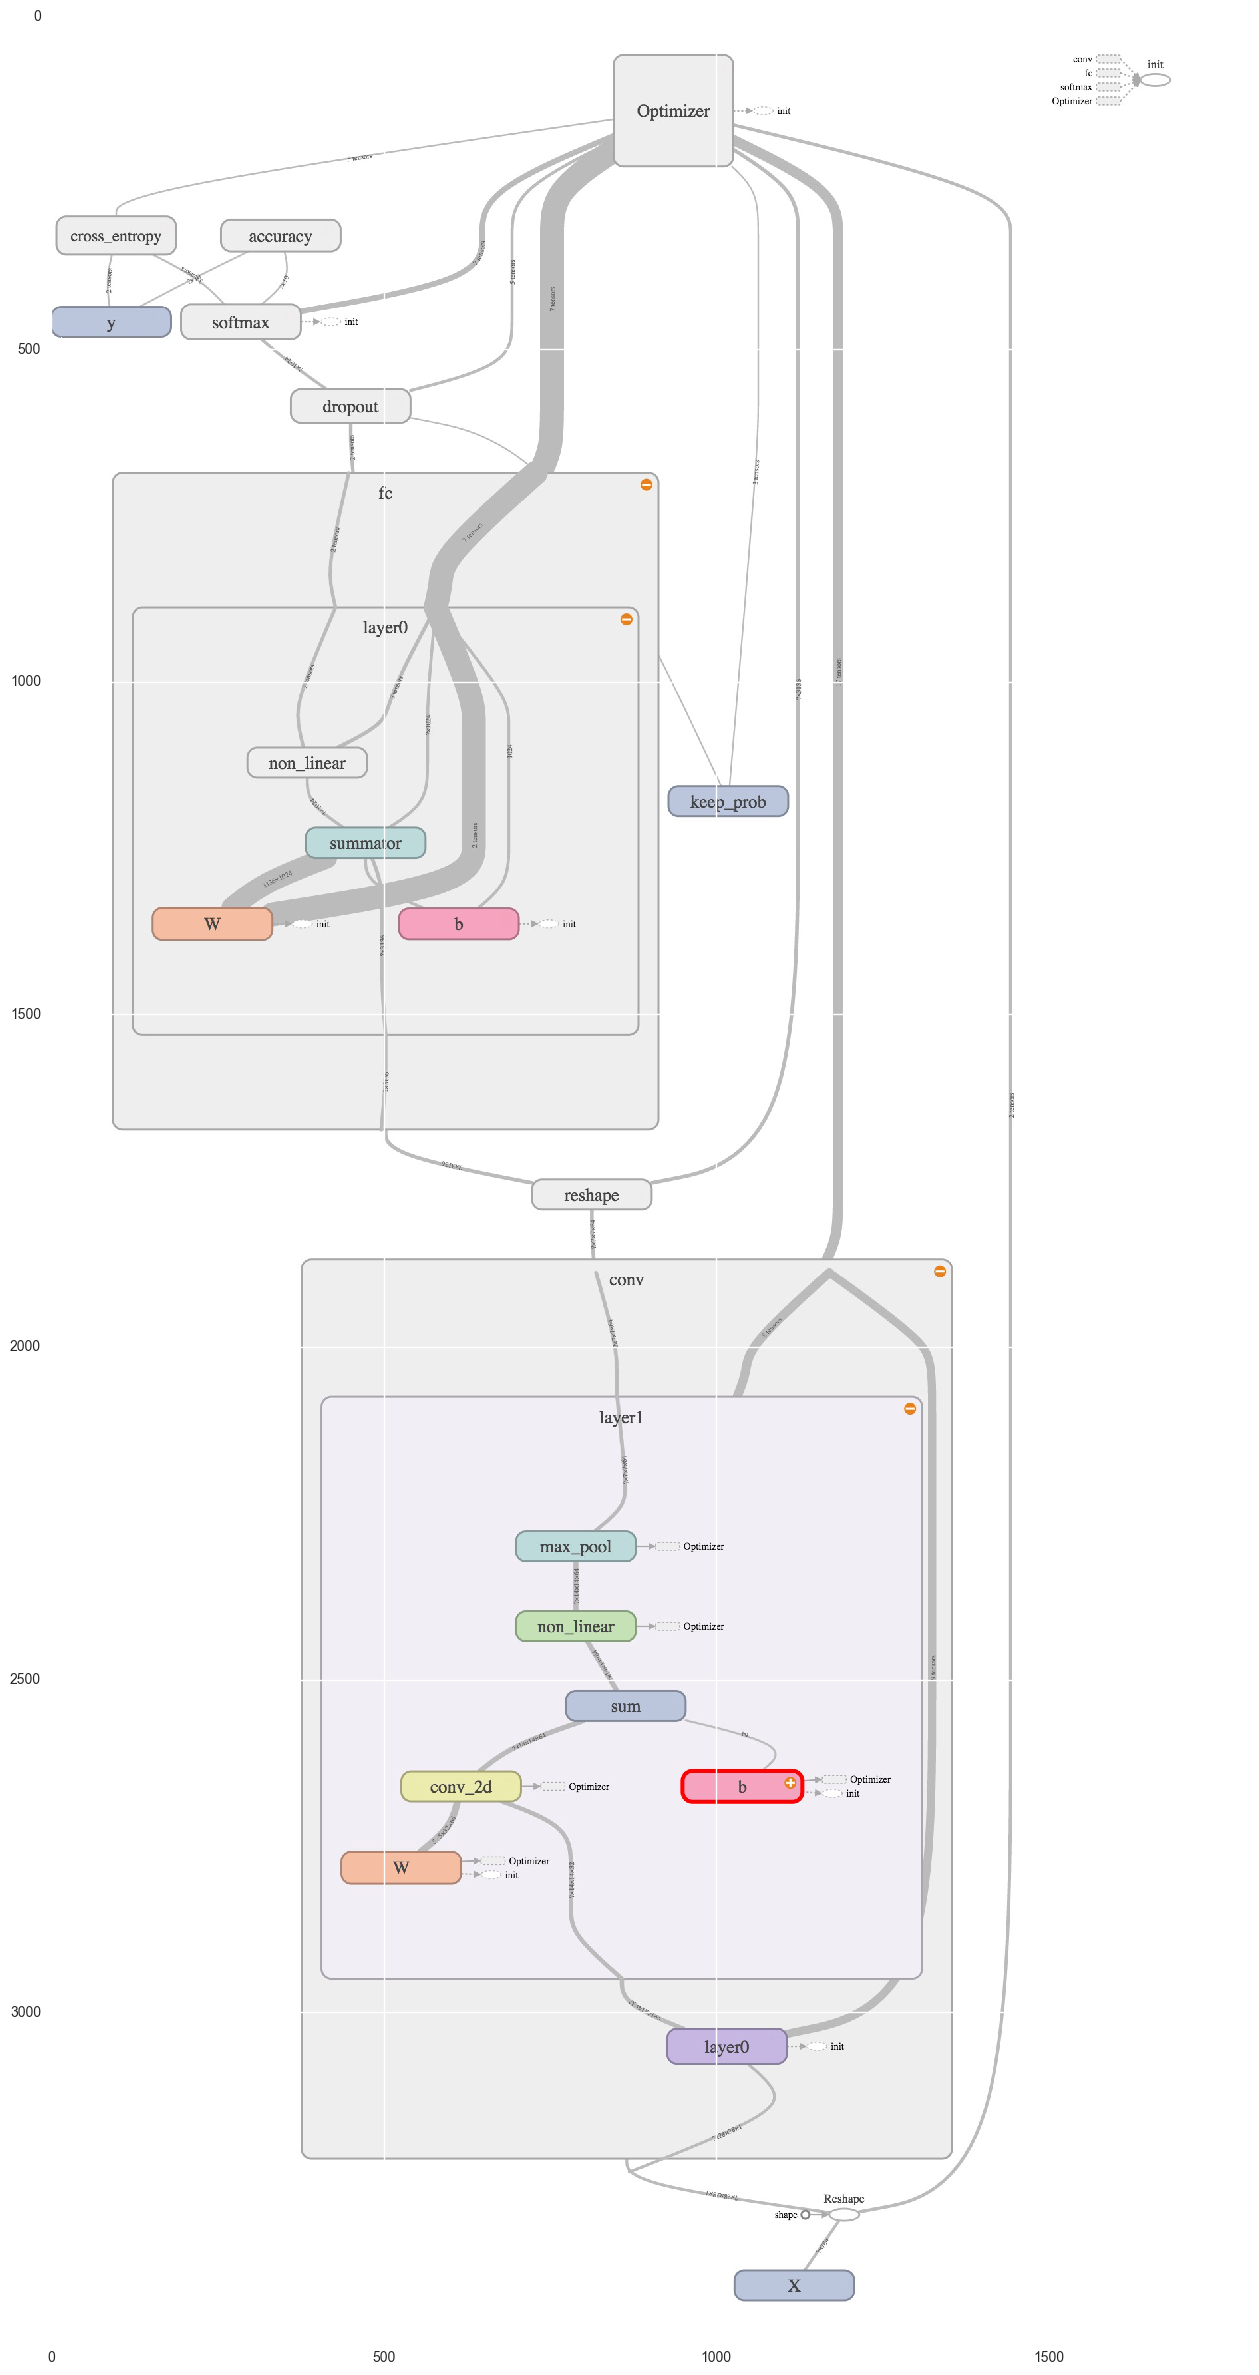

In [24]:
#lets look at the graph
print_img_from_clipboard()

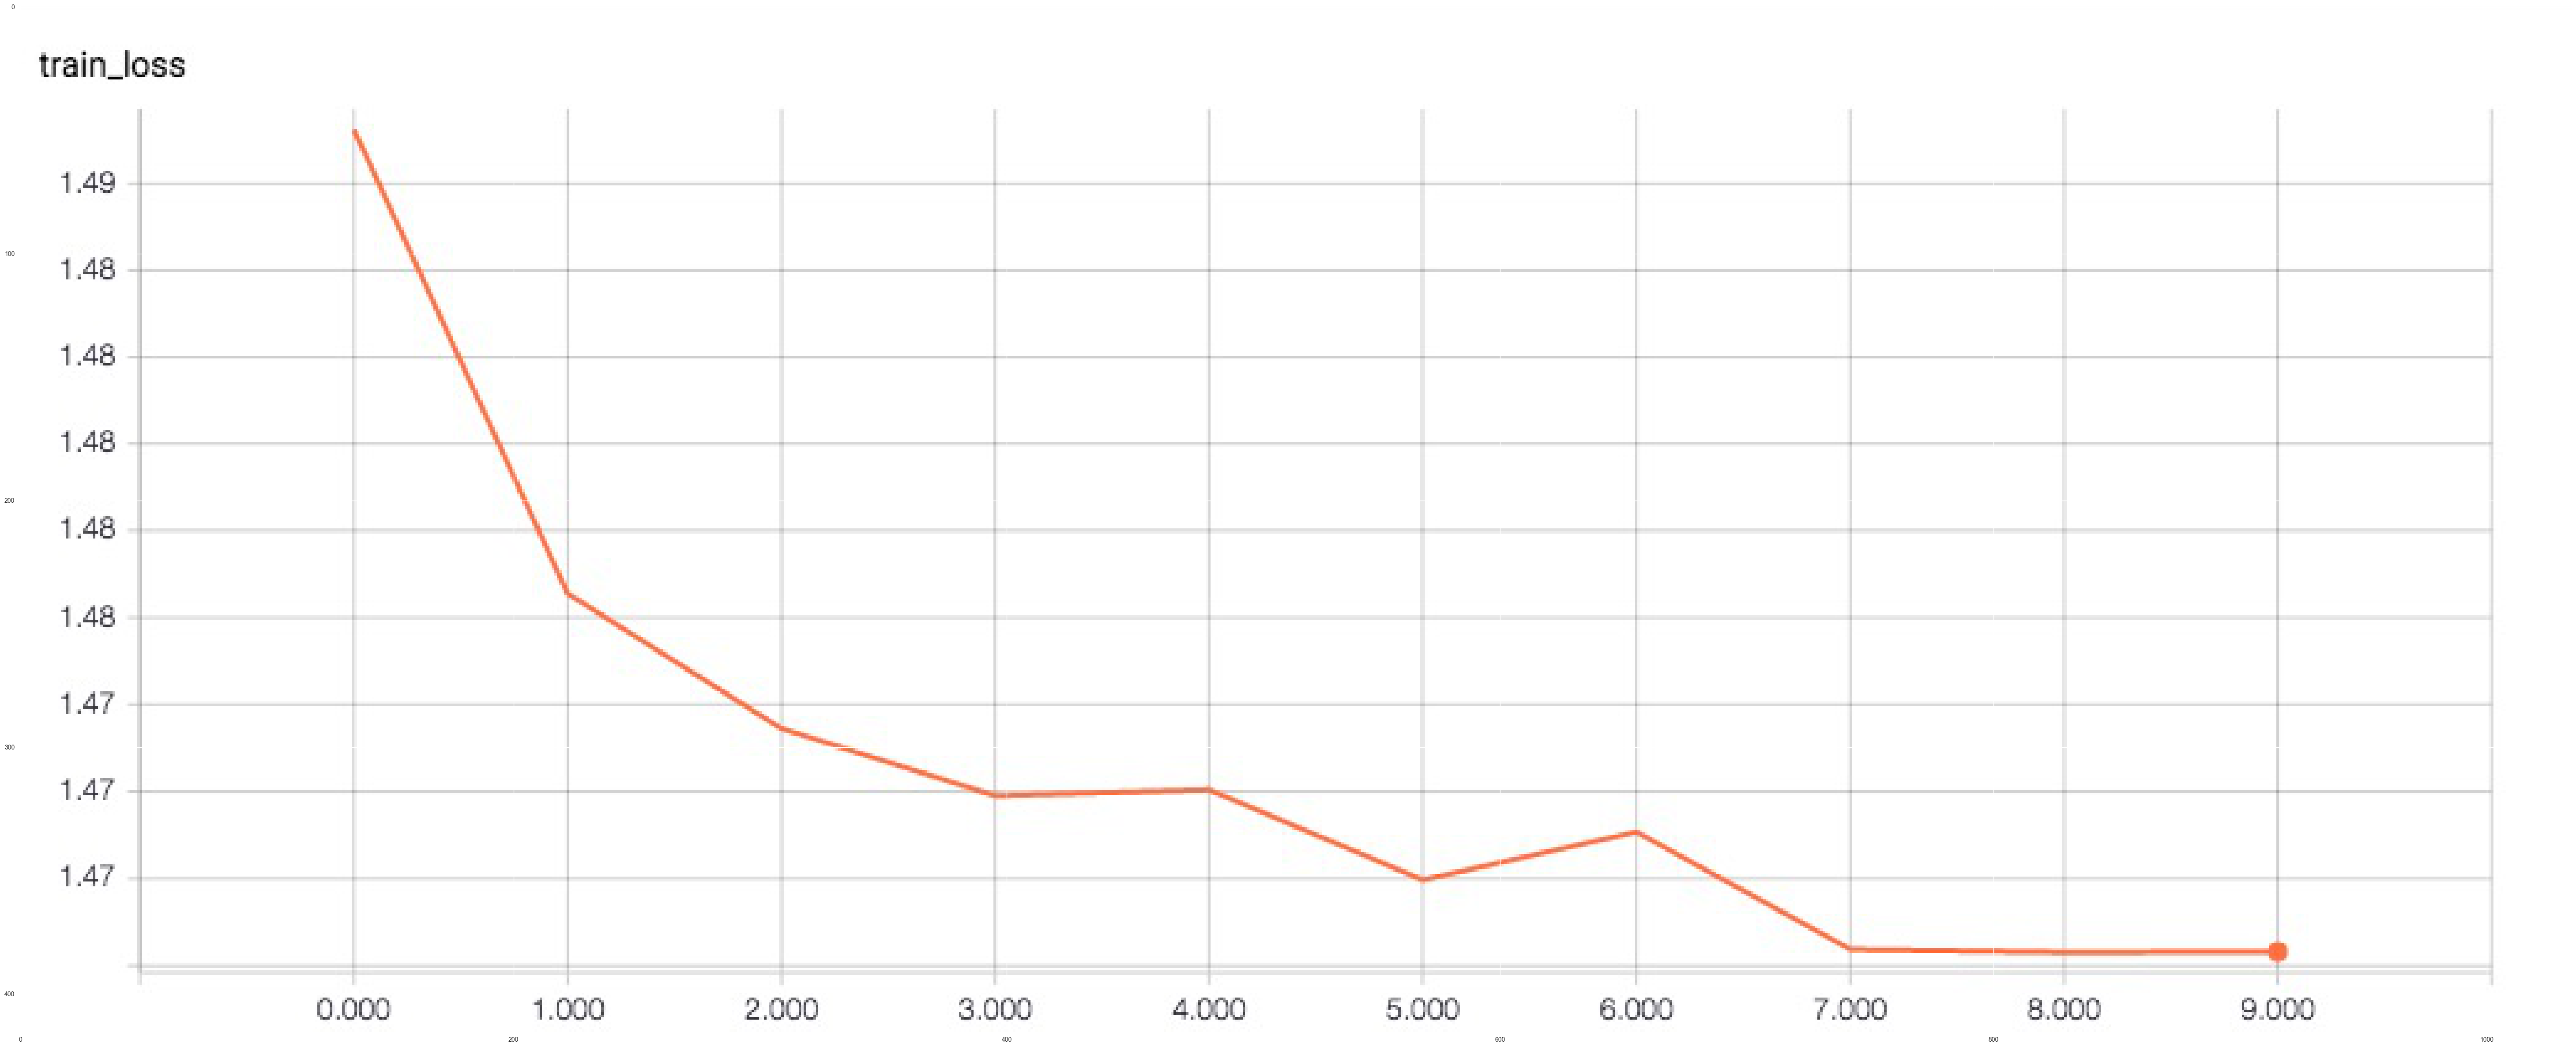

In [2]:
print_img_from_clipboard()

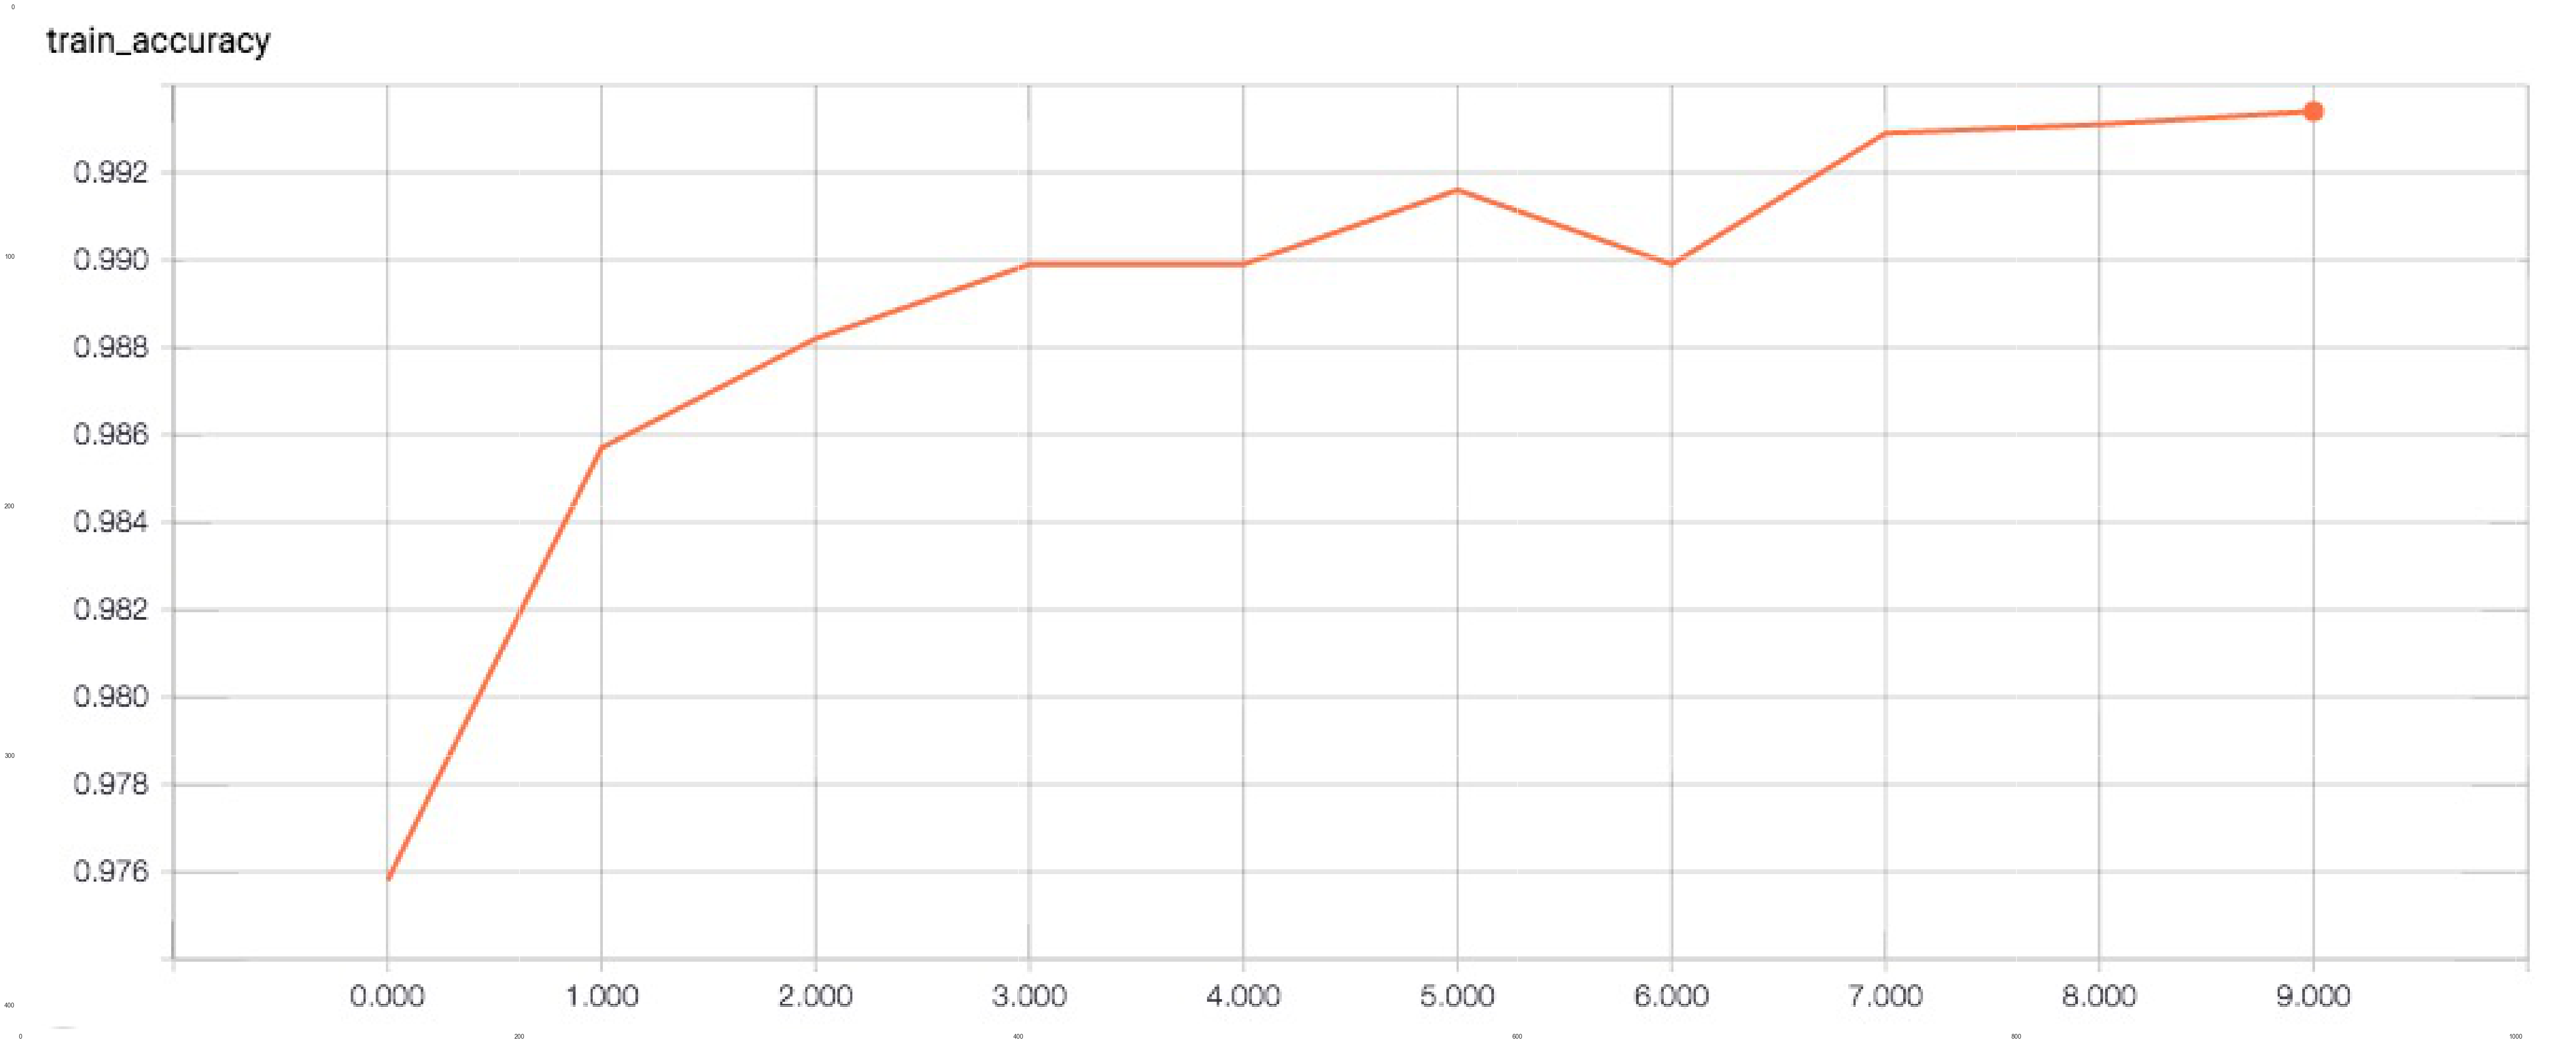

In [3]:
print_img_from_clipboard()

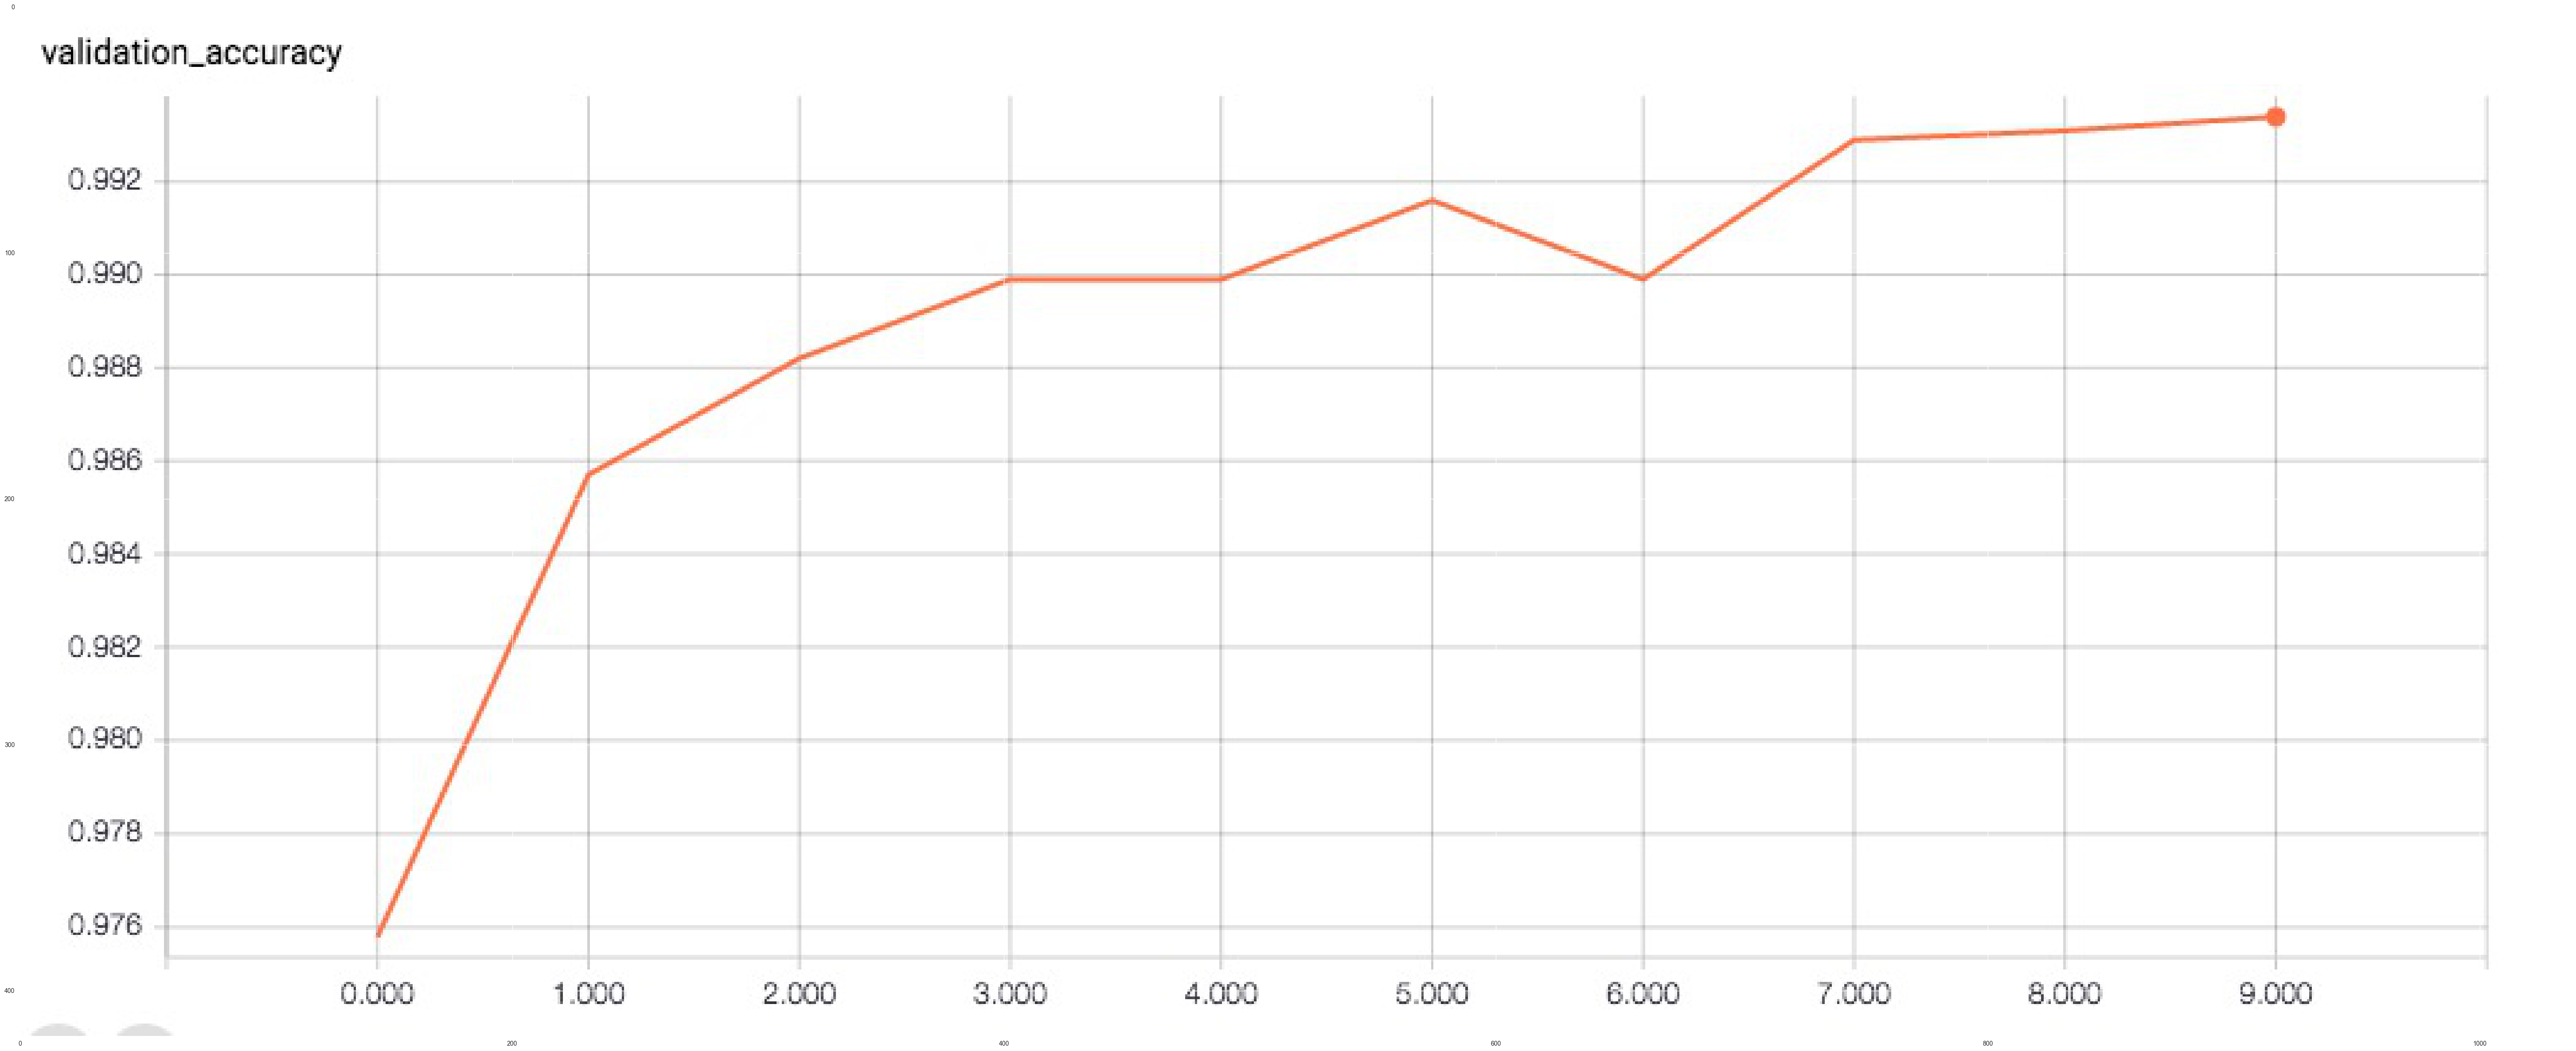

In [4]:
print_img_from_clipboard()